## 1. Two-dimensional data

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

### 1. Two-dimensional Histogram
$$p(x_i, y_j) = \frac{n_{ij}}{N}$$
$$x p(x_i, y_j) \propto \frac{n_{ij}}{N}$$

In [ ]:


class Histogram2D:
    def __init__(self, bins=20, range=None):
        self.bins = bins
        self.range = range

    def fit(self, X):
        hist, x_edges, y_edges = np.histogram2d(X[:,0], X[:,1],
                                                bins=self.bins,
                                                range=self.range)
        
        self.hist = hist / np.sum(hist)  
        self.x_edges = x_edges
        self.y_edges = y_edges
        
        self.hx = x_edges[1] - x_edges[0]
        self.hy = y_edges[1] - y_edges[0]

    def sample(self, n_samples):
        probs = self.hist.flatten()
        probs /= np.sum(probs)

        idx = np.random.choice(len(probs), size=n_samples, p=probs)
        ix = idx // self.bins
        iy = idx % self.bins

        xs = self.x_edges[ix] + np.random.rand(n_samples) * self.hx
        ys = self.y_edges[iy] + np.random.rand(n_samples) * self.hy
        
        samples = np.stack([xs, ys], axis=1)
        return samples

    def score_samples(self, X):
        ix = np.searchsorted(self.x_edges, X[:,0], side='right') - 1
        iy = np.searchsorted(self.y_edges, X[:,1], side='right') - 1
        
        ix = np.clip(ix, 0, self.bins - 1)
        iy = np.clip(iy, 0, self.bins - 1)

        probs = self.hist[ix, iy]

        probs = np.maximum(probs, 1e-12)
        logp = np.log(probs)
        
        return logp


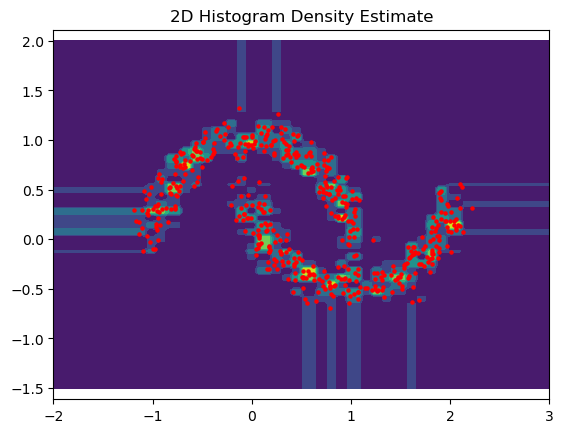

In [12]:


# 生成数据
X, _ = make_moons(n_samples=500, noise=0.1)

# 训练模型
hist_model = Histogram2D(bins=30)
hist_model.fit(X)

# 可视化 learned density
xx, yy = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-1.5, 2, 100))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
logp = hist_model.score_samples(grid).reshape(xx.shape)

plt.contourf(xx, yy, np.exp(logp))
plt.scatter(X[:,0], X[:,1], s=5, color='r')
plt.axis('equal')
plt.title("2D Histogram Density Estimate")
plt.show()


### 2. Single Gaussian

In [16]:
class SingleGaussian:
    def __init__(self):
        self.mean = None
        self.cov = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        diff = X - self.mean
        self.cov = np.cov(diff.T, bias=True)
    
    def sample(self, n_samples):
        samples = np.random.multivariate_normal(self.mean, self.cov, size=n_samples)
        return samples
    
    def score_samples(self, X):
        # log p(x) = -1/2 [ (x-μ)^T Σ^{-1} (x-μ) + log|Σ| + D*log(2π) ]
        D = X.shape[1]
        diff = X - self.mean
        inv_cov = np.linalg.inv(self.cov)
        det_cov = np.linalg.det(self.cov)
        exp_term = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        logp = -0.5 * (exp_term + np.log(det_cov) + D * np.log(2 * np.pi))
        
        return logp

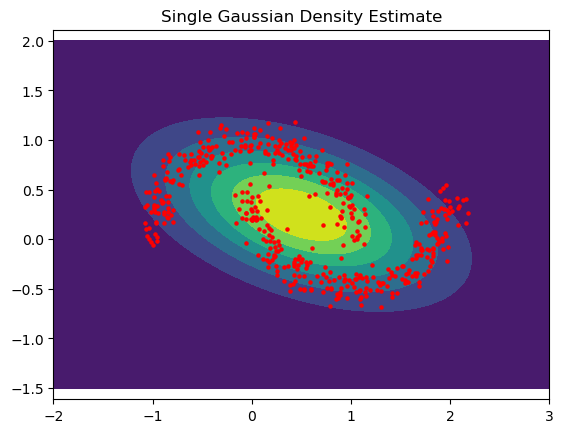

In [17]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 生成数据
X, _ = make_moons(n_samples=500, noise=0.1)

# 拟合单高斯
g = SingleGaussian()
g.fit(X)

# 评估密度
xx, yy = np.meshgrid(np.linspace(-2, 3, 200),
                     np.linspace(-1.5, 2, 200))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
logp = g.score_samples(grid).reshape(xx.shape)

plt.contourf(xx, yy, np.exp(logp))
plt.scatter(X[:,0], X[:,1], s=5, color='r')
plt.axis('equal')
plt.title("Single Gaussian Density Estimate")
plt.show()

### 3. GMM（Gaussian Mixture Model）

In [20]:
from scipy.stats import multivariate_normal
class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        self.K = n_components      
        self.max_iter = max_iter   
        self.tol = tol 
    
    def fit(self, X):
        N, D = X.shape
        
        np.random.seed(0)
        self.pi = np.ones(self.K) / self.K
        self.mu = X[np.random.choice(N, self.K, replace=False)]
        self.sigma = np.array([np.cov(X.T) for _ in range(self.K)])
        
        log_likelihood_old = 0

        for step in range(self.max_iter):
            # E-step
            gamma = np.zeros((N, self.K))
            for k in range(self.K):
                gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])
            gamma /= np.sum(gamma, axis=1, keepdims=True)

            # M-step
            Nk = np.sum(gamma, axis=0)
            self.pi = Nk / N
            self.mu = (gamma.T @ X) / Nk[:, np.newaxis]
            self.sigma = np.zeros((self.K, D, D))
            for k in range(self.K):
                diff = X - self.mu[k]
                self.sigma[k] = (gamma[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

            log_likelihood = np.sum(np.log(np.sum([
                self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])
                for k in range(self.K)
            ], axis=0)))
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
    
    def sample(self, n_samples):
        component = np.random.choice(self.K, size=n_samples, p=self.pi)
        samples = np.array([
            np.random.multivariate_normal(self.mu[k], self.sigma[k])
            for k in component
        ])
        return samples
    
    def score_samples(self, X):
        pdf = np.sum([
            self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])
            for k in range(self.K)
        ], axis=0)
        return np.log(pdf + 1e-12)

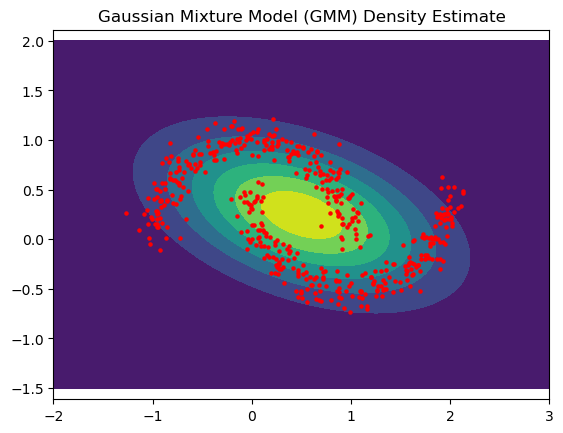

In [23]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, _ = make_moons(n_samples=500, noise=0.1)

gmm = GMM(n_components=1)
gmm.fit(X)

xx, yy = np.meshgrid(np.linspace(-2, 3, 200),
                     np.linspace(-1.5, 2, 200))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
logp = gmm.score_samples(grid).reshape(xx.shape)

plt.contourf(xx, yy, np.exp(logp))
plt.scatter(X[:,0], X[:,1], s=5, color='r')
plt.axis('equal')
plt.title("Gaussian Mixture Model (GMM) Density Estimate")
plt.show()


### 4. KDE (Kernel Density Estimation) with a Gaussian Kernel

In [ ]:
class GaussianKDE:
    def __init__(self, bandwidth=0.2):
        self.bandwidth = bandwidth
        self.X_train = None
        self.N = None
        self.D = None

    def fit(self, X):
        self.X_train = X
        self.N, self.D = X.shape

    def score_samples(self, X):
        h = self.bandwidth
        N, D = self.N, self.D
        Xq = X[:, None, :]            
        Xtrain = self.X_train[None, :, :] 

        diff = Xq - Xtrain            
        dist2 = np.sum(diff**2, axis=2)  

        kernel_vals = np.exp(-0.5 * dist2 / (h**2))

        norm_const = (2 * np.pi)**(D/2) * (h**D) * N
        p = np.sum(kernel_vals, axis=1) / norm_const

        return np.log(p + 1e-12)  

    def sample(self, n_samples):
        idx = np.random.choice(self.N, size=n_samples, replace=True)
        centers = self.X_train[idx]
        noise = np.random.randn(n_samples, self.D) * self.bandwidth
        return centers + noise

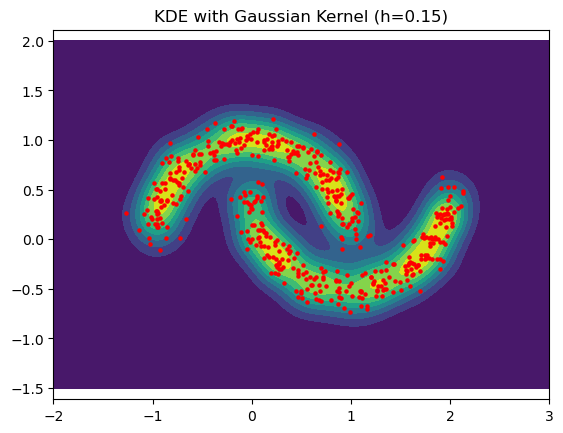

In [25]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 生成数据
X, _ = make_moons(n_samples=500, noise=0.1)

# 拟合 KDE 模型
kde = GaussianKDE(bandwidth=0.15)
kde.fit(X)

# 计算密度
xx, yy = np.meshgrid(np.linspace(-2, 3, 200),
                     np.linspace(-1.5, 2, 200))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
logp = kde.score_samples(grid).reshape(xx.shape)

# 可视化
plt.contourf(xx, yy, np.exp(logp))
plt.scatter(X[:,0], X[:,1], s=5, color='r')
plt.axis('equal')
plt.title("KDE with Gaussian Kernel (h=0.15)")
plt.show()
